# Introduction to atomman: Differential displacement maps

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction <a id='section1'></a>

This Notebook provides usage details and examples for generating differential displacement (dd) maps for analyzing dislocation structures.  

**Library Imports**

In [1]:
# Standard Python libraries
from copy import deepcopy
import datetime

# http://www.numpy.org/
import numpy as np

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.5.0
Notebook executed on 2025-02-24


## 2. Theory

Dislocation core structures can also be characterized using differential displacement maps as first used by [Vitek, Perrin and Bowen](https://doi.org/10.1080/14786437008238490). 

For every pair of neighboring atoms $\alpha$ and $\beta$, a differential displacement vector, $d_{i \alpha \beta}$ is computed as

$$ d_{i \alpha \beta} =  x_{i \alpha \beta} - X_{i \alpha \beta} $$

where $x_{i \alpha \beta}$ is the vector difference between atoms $\alpha$ and $\beta$ in the current (defect) configuration, and $X_{i \alpha \beta}$ is the vector difference between atoms $\alpha$ and $\beta$ in the reference (perfect crystal) configuration.  

Plots are then constructed where atomic positions are shown as circles with arrows representing components of $d_{i \alpha \beta}$. The arrows are centered halfway between the two atoms $\alpha$ and $\beta$ for which that particular $d_{i \alpha \beta}$ was computed.  For most variations, the direction of the arrows indicate the two atoms $\alpha$ and $\beta$ that $d_{i \alpha \beta}$ was computed for. Various plotting options and variations are described in more detail below.

*Update version 1.3.2* A DifferentialDisplacement class was introduced to make it easier to generate differential displacement maps and to allow for more options with different materials systems by separating the differential displacement calculation from the plotting.  The class is meant to replace the old differential_displacement function.

## 3. Generating dd maps with the DifferentialDisplacement class

The atomman.defect.DifferentialDisplacement class allows for the creation of differential displacement maps in two steps:
1. The dd vectors are computed for all atoms when a DifferentialDisplacement object is initialized.
2. A dd map is constructed using the calculated vectors by calling DifferentialDisplacement.plot().

These operations are separated out so that the dd vectors themselves only need to be computed once per system rather than every time that plot is called.  This is beneficial as depending on your system you may wish to plot different components of the dd vectors and/or modify some of the numerous plotting options to improve the appearance of the figures.

### 3.1. DifferentialDisplacement initialization/solve

The differential displacement vectors are computed when a DifferentialDisplacement object is initialized.  

- __system_0__ (*atomman.system*) The defect-free base system to use that has atom ids compatible and consistent with system_1.
- __system_1__ (*atomman.system*) The defect system to use.
- __neighbors__ (*atomman.NeighborList, optional*) The neighbor list to use when computing the dd vectors.  This should be computed for system_0 if reference=0 and from system_1 if reference=1.
- __cutoff__ (*float, optional*) A cutoff distance for computing a neighbor list if neighbors is not directly given. If reference = 0, then system_0 will be used to generate the list. If reference = 1, then system_1 will be used to generate the list.
- __reference__ (*int, optional*) Indicates which of two systems (0 or 1) that the atom positions shown in the map are to be taken from.  This is typically 1 as that will show how the atoms have moved due to the presence of the dislocation.  A value of 0 can be useful if you wish to see the dd vectors mapped onto the ideal crystal.  

__Caution!!!__: The dd vector algorithm directly compares the relative position vectors for pairs of atoms in the two systems according to the atom ids.  As such, care must be taken to ensure that the atom ids remain consistent and compatible between the two systems.  It should be as if system_0 is system_1 except for the lack of the dislocation(s).  The easiest way to do this is to have the Dislocation class return a base system when a dislocation system is constructed as the base system generated will be designed to be compatible.  Also, if you replicate the systems after generating them you need to avoid wrapping atoms around the periodic boundaries prior to replicating otherwise the wrapped atoms will be computed as having large dd vectors.



### 3.1.1. Computing the neighbor list and the dd vectors

Either system_0 or system_1 can be used as the reference state for identifying neighbors and plotting atomic positions. 

- Using system_1 as the reference state will overlay the differential displacement vectors onto the relaxed atomic positions.  This provides insight for the dislocation both in terms of its atomic nature and core spreading. This is the more common representation, especially for dislocations with large edge components.
- Using system_0 as the reference state will overlay the differential displacement vectors onto a perfect crystal.  This indicates how the crystal needs to be deformed to introduce the dislocation.

In [2]:
# Load dislocation configurations that were previously constructed using Dislocation class
base_system = am.load('atom_dump', 'files/fcc_Al_base.dump')
disl_system = am.load('atom_dump', 'files/fcc_Al_disl.dump')
alat = uc.set_in_units(4.05, 'Å')
burgers = np.array([0.0, alat / 2**0.5, 0.0])

base_neighbors = base_system.neighborlist(cutoff = 0.9*alat)
disl_neighbors = disl_system.neighborlist(cutoff = 0.9*alat)

In [3]:
dd = am.defect.DifferentialDisplacement(base_system, disl_system, neighbors=disl_neighbors, reference=1)
# or
#dd = am.defect.DifferentialDisplacement(base_system, disl_system, neighbors=base_neighbors, reference=0)

### 3.1.2. Raw differential displacement data

The dd vector data can be retrieved without generating a plot using the following attributes. 

- __ddvectors__ are the computed differential displacement vectors for each pair of neighbor atoms. Note that these are the full raw values computed during the class initialization and have not been normalized with ddmax.
- __arrowcenters__ are the center positions for each of the differential displacement vector arrows. These points are the midpoints between the pair of neighbor atoms used to compute the differential displacement vectors. 
- __arrowuvectors__ are the unit vectors associated with the relative position vectors for each pair of neighbor atoms used to compute the differential displacement vectors.  These are used by all component options except for 'projection' to determine the direction of the plotted dd vectors. 

In [4]:
print(dd.ddvectors.shape)
print(dd.ddvectors)

(387340, 3)
[[ 0.00030753  0.00574007  0.0056176 ]
 [ 0.00015473  0.00286493  0.00279437]
 [-0.0001565  -0.00285422 -0.00276553]
 ...
 [-0.00012418  0.00269864 -0.00278591]
 [-0.00012418  0.00269864 -0.00278591]
 [-0.00025094  0.00539228 -0.00554786]]


In [5]:
print(dd.arrowcenters.shape)
print(dd.arrowcenters)

(387340, 3)
[[   2.4866357  -112.592277   -109.13996141]
 [   1.24650369 -113.30966101 -109.14137303]
 [   3.72645929 -114.74441346 -109.14415298]
 ...
 [   5.38094613  108.99060147 -118.48030553]
 [   7.86105735  108.99060147 -118.48030553]
 [   6.62093836  109.70789473 -118.48168651]]


In [6]:
print(dd.arrowuvectors.shape)
print(dd.arrowuvectors)

(387340, 3)
[[ 1.07171033e-04  9.99998078e-01  1.95767095e-03]
 [-8.65578157e-01  5.00772906e-01  9.75316053e-04]
 [ 8.65579630e-01 -5.00770378e-01 -9.65254013e-04]
 ...
 [-8.65627722e-01  5.00687230e-01 -9.72312841e-04]
 [ 8.65605989e-01  5.00724801e-01 -9.72385803e-04]
 [-8.74616512e-05  9.99998127e-01 -1.93360212e-03]]


### 3.2. DifferentialDisplacement plotting

DifferentialDisplacement.plot() creates a differential displacement map as a matplotlib figure.  There are many options to help control what is plotted as well as give you options for tweaking how the plots look.

Basic parameters
- __component__ (*str or array-like object*) Indicates the component(s) of the differential displacement to plot.
    - Values of 'x', 'y', or 'z' will plot the component along that Cartesian direction.
    - A value of 'projection' will plot the differential displacement vectors as projected onto the plotting plane, thereby showing the two components perpendicular to the line direction. This is commonly used with screw dislocations to show the "edge" displacements.
    - If a 3D vector is given, then the component parallel to that direction will be used.  Useful for mixed dislocations as you can plot along the Burgers vector direction.
 - __ddmax__ (*float or None*) The maximum dd vector length allowed. Values will be kept between +-ddmax by wrapping values with larger absolute values around by adding/subtracting 2\*ddmax.  This normalization helps make it so the dd vectors are large only near the dislocation cores and not along the planes where the dislocations have slipped.
    - The typical value for full dislocations is |b|/2.
    - For fcc a/2<110> dislocations and basal hcp dislocations, |b|/4 is used as it makes the dd vectors small both in the bulk crystal and in the stacking fault region.
    - If ddmax is set to None, then no wrapping is done and the dd vectors will reflect all slip that occurred in transforming from system_0 to system_1.
- __plotxaxis__ (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting x-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'x' = \[1, 0, 0\].  Typically, this is selected to align with the dislocation solution's m-axis.
- __plotyaxis__ (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting y-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'y' = \[0, 1, 0\].  Typically, this is selected to align with the dislocation solution's n-axis.
- __figsize__ (*float or tuple, optional*) Specifies the size of the figure to create in inches.  If a single value is given, it will be used for the figure's width, and the height will be scaled based on the xlim and ylim values.  Alternatively, both the width and height can be set by passing a tuple of two values, but the plot will not be guaranteed to be "regular" with respect to length dimensions.
- __matplotlib_axes__ (*matplotlib.Axes.axes, optional*) Provides aAn existing matplotlib axes objec to add the plot to rather than creating a new plott.   Th    allows for subplots to be constructed.  Note that figsize will be igno     as the figure would have to be created beforehand and no autom      optimum scaling of the figure's dimensions will occur.

Plot range limits
- __xlim__ (*tuple, optional*) The minimum and maximum coordinates along the plotting x-axis to include in the fit.  Values are taken in the specified length_unit. If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.
- __ylim__ (*tuple, optional*) The minimum and maximum coordinates along the plotting y-axis to include in the fit.  Values are taken in the specified length_unit. If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.
- __zlim__ (*tuple, optional*) The minimum and maximum coordinates normal to the plotting axes (i.e. plotxaxis X plotyaxis) to include in the fit.  Values are taken in the specified length_unit.  The optimum zlim should encompass only a single periodic slice along this direction.  If not given, then the limits are set based on min and max atomic coordinates along the axis.

DD vector arrow options
- __arrowscale__ (*float, optional*) Scaling factor for the magnitude of the differential displacement arrows.  Default value is 1: no scaling, vectors are in units of length. For major components, this is often set such that the max differential displacement component after wrapping (see normfactor) is scaled to the distance between the atom pairs in the plot.  For minor components, this is often set to a large value simply to make the components visible.
- __arrowwidth__ (*float, optional*) Scaling factor to use for the width of the plotted arrows. Default value is 0.005 = 1/200.

Atom circle options
- __atomcolor__ (*str or list, optional*) Matplotlib color name(s) to use to display the atoms.  If str, that color will be assigned to all atypes.  If list, must give a color value or None for each atype.  Default value (None) will use cmap instead. Note: atomcolor and atomcmap can be used together as long as exactly one color or cmap is given for each unique atype.
- __atomcmap__ (*str or list, optional*) Matplotlib colormap name(s) to use to display the atoms.  Atoms will be colored based on their positions and scaled using zlim. If str, that cmap will be assigned to all atypes.  If list, must give a cmap value or None for each atype.  Default value (None) will use 'hsv' cmap.  Note: atomcolor and atomcmap can be used together as long as exactly one color or cmap is given for each unique atype.
- __use0z__ (*bool, optional*) This is used for atoms if atomcmap is used.  If False (default), the z coordinates from the reference system will be used for zlim and atomcmap colors. If True, the z coordinates will be used from system0 even if system1 is the reference system.
- __atomsize__ (*float, optional*) The circle radius size to use for the plotted atom positions in units of length.  Default value is 0.5.

Returns

- (*matplotlib.Figure*) The generated figure.  This is returned to allow users to further modify it after creation.


#### 3.2.1. Common plotting settings

In [7]:
# Create dict of common plotting parameter values for all 
params = {}
params['ddmax'] = np.linalg.norm(burgers) / 4     # Use |b|/4 for a/2<110> fcc dislocations
params['plotxaxis'] = 'y'                         # Align plotting x-axis with the Cartesian y-axis, which is aligned with dislocation m-axis
params['plotyaxis'] = 'z'                         # Align plotting y-axis with the Cartesian z-axis, which is aligned with dislocation n-axis
params['figsize'] = 10                            # Plots will be "regular" if only one size value is given

params['xlim'] = (-20, 20)                        # Plotting limits for the plotting x-axis.  Large as this is along the slip plane  
params['ylim'] = (-5, 5)                          # Plotting limits for the plotting y-axis.  Small as this is perpendicular to the slip plane
params['zlim'] = (0.01, alat * 6**0.5 / 2 + 0.01)   # Should be one periodic length of the crystal along the dislocation line direction  

params['arrowwidth'] = 1/50                       # Made bigger to make arrows easier to see
params['arrowscale'] = 2.4                        # Typically chosen to make arrows of length ddmax touch the corresponding atom circles

#### 3.2.2. Plotting the different component options

- __'x'__, __'y'__, and __'z'__ plot the components of the dd vectors along the corresponding Cartesian axes of the system.
- The components of the dd vectors along an arbitrary Cartesian direction can be plotted by specifying a vector for the the component option.  This is useful for mixed dislocations where the Burgers vector does not align with any of the Cartesian axes.
- __'projection'__ plots the projection of the dd vectors onto the plotting plane.  This is primarily used by screw dislocations to view the localized edge displacements due to the dislocations.

__Note__:  There is a difference in what the directions of the plotted arrows represent for the component options and the projection option.  For the component options, the direction of the arrows are always aligned with the relative position vectors of the pair of atoms that each dd vector is associated with.  For the projection option, the arrows are the 2D projection of the dd vectors and therefore have a 2D direction.  

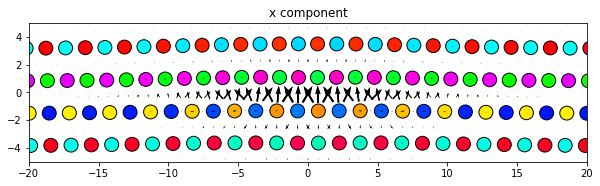

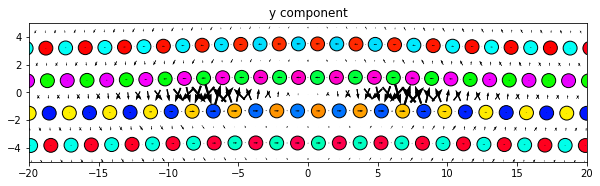

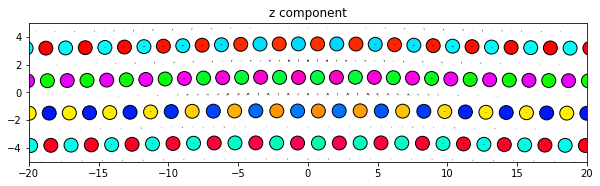

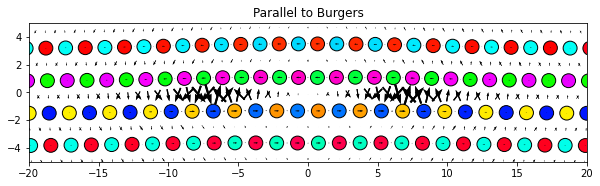

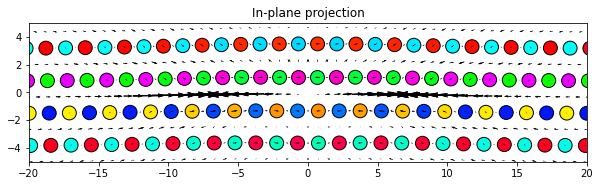

In [8]:
dd.plot('x', **params)
plt.title('x component')
plt.show()

dd.plot('y', **params)
plt.title('y component')
plt.show()

dd.plot('z', **params)
plt.title('z component')
plt.show()

dd.plot(burgers, **params)
plt.title('Parallel to Burgers')
plt.show()

dd.plot('projection', **params)
plt.title('In-plane projection')
plt.show()

### 3.2.3. Adding plots as subplots

Multiple dd plots can be included in the same figure object by first creating a figure and subplots and passing the specific axes in using the matplotlib_axes parameter.  

One caveat with this is that the figure size is controlled by the figsize parameter of the figure definition and not by the DifferentialDisplacement.plot() figsize parameter.  As such, making the plots look regular with comparable x,y coordinate spacings may require testing different combinations of size values.

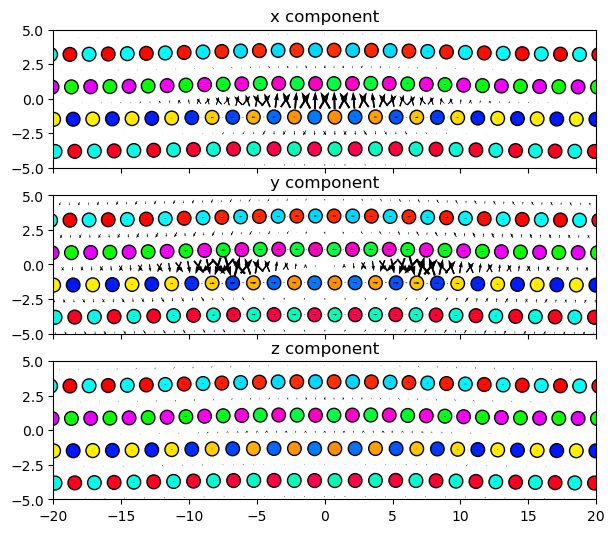

In [9]:
fig = plt.figure(figsize=(7, 6.1))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.set_title('x component')
ax2.set_title('y component')
ax3.set_title('z component')

dd.plot('x', matplotlib_axes=ax1, **params)
dd.plot('y', matplotlib_axes=ax2, **params)
dd.plot('z', matplotlib_axes=ax3, **params)
plt.show()

### 3.2.4. Changing the atom colors

The default settings color the atoms based on their out-of-plane coordinates relative to the zlim values.

If there are multiple atom types in your system, the atomcmap and atomcolor parameters can be lists allowing for different color schemes for each atype.  The atomcmap and atomcolor styles can be mixed by using list values in which each element of the two lists has a color/map value in one list and a None value in the other. For example, atomcmap=\['hsv', None\], atomcolor=\[None, 'black'\] will make the first atom type have variable colors and the second atom type to always be black.

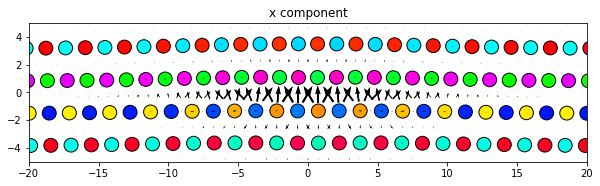

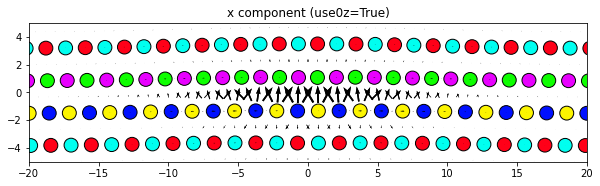

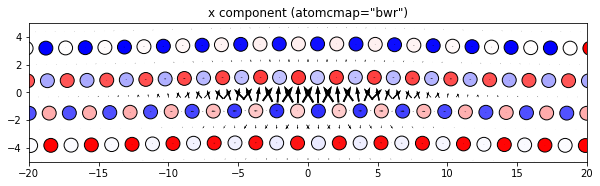

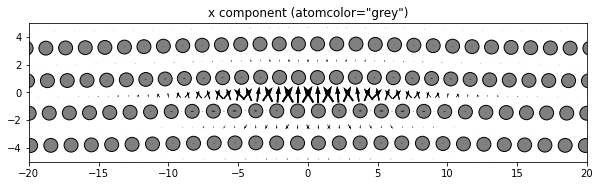

In [10]:
# Redo the original for reference
dd.plot('x', **params)
plt.title('x component')
plt.show()

# Color atoms based on out-of-plane coordinates of base system
dd.plot('x', use0z=True, **params)
plt.title('x component (use0z=True)')
plt.show()

# Use a different color map for the atoms
dd.plot('x', atomcmap='bwr', **params)
plt.title('x component (atomcmap="bwr")')
plt.show()

# Color all atoms the same color
dd.plot('x', atomcolor='grey', **params)
plt.title('x component (atomcolor="grey")')
plt.show()

## 3.3. Combined DD map and Nye tensor plots

The Nye tensor provides an alternate means of visualizing the local distortions due to the presence of a dislocation.  Nye tensor plots in atomman using the atomman.defect.Strain class.  This section outlines how to generate a combined figure which overlays dd vectors onto Nye tensor plots.

The DifferentialDisplacement.plot_with_nye method generates the combined DD map and Nye tensor plots.  It takes all of the same parameters as the basic plot() method with extra settings for controlling how the Nye tensor is displayed.

Nye tensor parameters

- __strain__: An atomman.defect.Strain object to use for computing the Nye tensor values.
- __cmap__: The name of the matplotlib color map to use with the Nye tensor. The default value is 'bwr'.
- __vlim__: The minimum and maximum values to use when mapping the Nye tensor values to the color map.  The default behavior is to use the range of the associated Nye tensor component. 
- __xbins__: The number of interpolation bins to use along the plotting x-axis direction for the Nye tensor.  Note that the total bins for the plot is xbins*ybins.  Default value is 200.
- __ybins__: The number of interpolation bins to use along the plotting x-axis direction for the Nye tensor.  Note that the total bins for the plot is xbins*ybins.  Default value is 200.
- __colorbar__: Boolean indicating if the plot will include a color bar scale for the Nye tensor values.  Default value is True.
- __fill_value__: The Nye tensor values to use in any grid bins in which interpolation is not possible.  The default value of np.nan may result in errors being thrown when the plotting range exceeds the system dimensions.

### 3.3.1. Use the Strain class to compute the Nye tensor values

In [11]:
# Compute Nye tensors using the Strain class and the neighbors lists
strain = am.defect.Strain(disl_system, neighbors=disl_neighbors, basesystem=base_system, baseneighbors=base_neighbors)
strain.solve_nye()

### 3.3.2. Define the common plotting parameters to use.


In [12]:
# Copy all parameters from the pure dd plots above 
params2 = deepcopy(params)

# Add Nye tensor specific parameters
params2['strain'] = strain
#params2['zlim'] = (0, bmag + 0.5)
params2['cmap'] = 'bwr'

# Set vlim based on all Nye components
vmax = np.abs(strain.nye).max()
params2['vlim'] = np.array([-vmax, vmax])

### 3.3.3. Plot

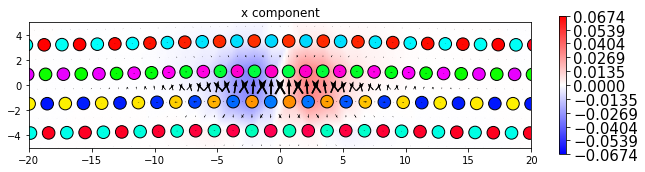

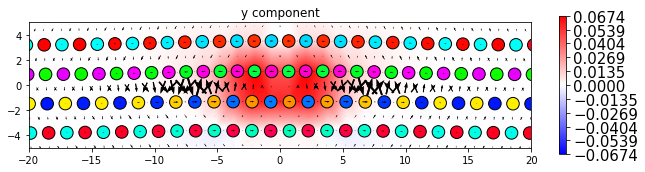

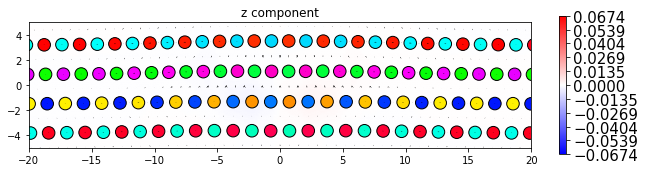

In [13]:
dd.plot_with_nye('x', **params2)
plt.title('x component')
plt.show()

dd.plot_with_nye('y', **params2)
plt.title('y component')
plt.show()

dd.plot_with_nye('z', **params2)
plt.title('z component')
plt.show()